In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance

PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/houston_processed.feather'),
 PosixPath('data/houston_processed_miles_time_diff.feather'),
 PosixPath('data/location_history.json')]

In [2]:
df = pd.read_feather(PATH/'houston_processed.feather')

In [3]:
print(df.shape)
print(df.head(3).T)

(353793, 21)
   accuracy  altitude  heading  velocity  verticalAccuracy  act_conf1  \
0         8      30.0    161.0       0.0               NaN      100.0   
1         3      30.0    307.0       0.0               NaN        NaN   
2         6      31.0    320.0       0.0               NaN        NaN   
3         5      31.0    320.0       0.0               NaN      100.0   
4        12       NaN      NaN       NaN               NaN        NaN   

  act_type1  act_cont2 act_type2  extra_intVal    ...     extra_type  \
0     STILL        NaN      None           NaN    ...           None   
1      None        NaN      None           NaN    ...           None   
2      None        NaN      None           NaN    ...           None   
3   TILTING        NaN      None           NaN    ...           None   
4      None        NaN      None           NaN    ...           None   

                         date_time  year  month  day  day_of_week  hour  \
0 2013-12-08 14:58:27.870000-06:00  2013

In [4]:
df.dtypes

accuracy                                 int64
altitude                               float64
heading                                float64
velocity                               float64
verticalAccuracy                       float64
act_conf1                              float64
act_type1                               object
act_cont2                              float64
act_type2                               object
extra_intVal                           float64
extra_name                              object
extra_type                              object
date_time           datetime64[ns, US/Central]
year                                     int64
month                                    int64
day                                      int64
day_of_week                              int64
hour                                     int64
minute                                   int64
latitude                               float64
longitude                              float64
dtype: object

In [5]:
# # convert timestamp
# df['date_time'] = pd.to_datetime(df.timestampMs,unit='ms').dt.tz_localize('utc').dt.tz_convert('US/Central')

# df['year']=df.date_time.dt.year

# df['month']=df.date_time.dt.month

# df['day']=df.date_time.dt.day

# df['day_of_week']=df.date_time.dt.dayofweek

# df['hour']=df.date_time.dt.hour
# df['minute'] = df.date_time.dt.minute

# # convert lat - long
# df['latitude'] = df.latitudeE7 / 1e7
# df['longitude'] = df.longitudeE7 / 1e7

# df.drop(['latitudeE7','longitudeE7','timestampMs'],axis=1,inplace=True)

# df.to_feather(PATH/'houston_processed.feather')

In [5]:
# remove year 2013 due to lack of records
# idx_drop = df[df.year==2013].index

# df.drop(idx_drop,inplace=True)

# df.reset_index(drop=True,inplace=True)

In [8]:
df.groupby('year').count()

,accuracy,altitude,heading,velocity,verticalAccuracy,act_conf1,act_type1,act_cont2,act_type2,extra_intVal,extra_name,extra_type,date_time,month,day,day_of_week,hour,minute,latitude,longitude
year,,,,,,,,,,,,,,,,,,,,
2015,25114,7278,3822,483,0,17925,17925,10276,10276,0,0,0,25114,25114,25114,25114,25114,25114,25114,25114
2016,288622,148499,51228,4592,0,149389,149389,72541,72541,0,0,0,288622,288622,288622,288622,288622,288622,288622,288622
2017,29133,15132,4867,612,0,16005,16005,8050,8050,51,51,51,29133,29133,29133,29133,29133,29133,29133,29133


# Miles diff

In [9]:
# df_year = df[df.year==2015].copy()
# s=0
# e=len(df_year)-1

In [10]:
def calculate_distance(lat1,long1,lat2,long2):
    return float("{0:.2f}".format(distance((lat1,long1),(lat2,long2)).miles))

In [11]:
lat2 = df.latitude.values
lat1 = df.latitude.shift().values
long2 = df.longitude.values
long1 = df.longitude.shift().values

In [12]:
# df_year['longitude_shift'] = df.longitude.shift()
# df_year['latitude_shift'] = df.latitude.shift()

# df_year.loc[0,'longitude_shift']=df_year.loc[0,'longitude']
# df_year.loc[0,'latitude_shift']=df_year.loc[0,'latitude']

# def miles_diff(row):
#     lat1,long1 = row['latitude_shift'],row['longitude_shift']
#     lat2,long2 = row['latitude'],row['longitude']
#     return calculate_distance(lat1,long1,lat2,long2)

In [27]:
# %%time
# temp=df_year.apply(miles_diff,axis=1)

CPU times: user 13 s, sys: 6.61 ms, total: 13 s
Wall time: 13 s


In [33]:
# quick test
# calculate_distance(*df_year.loc[10,['latitude','longitude','latitude_shift','longitude_shift']].values)

0.01

In [34]:
lat2 = df.latitude.values.tolist()
long2 = df.longitude.values.tolist()

lat1 = df.latitude.shift().values.tolist()
lat1[0] = lat2[0]
long1 = df.longitude.shift().values.tolist()
long1[0] = long2[0]

In [35]:
from concurrent.futures import ProcessPoolExecutor
def multiprocessing(func, args, workers):
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, *args)
    return (list(res))

In [36]:
args = [lat1,long1,lat2,long2]

In [37]:
%%time
mile_diff = multiprocessing(calculate_distance,args,4)

CPU times: user 2min 7s, sys: 21.8 s, total: 2min 29s
Wall time: 2min 34s


In [38]:
df['mile_diff'] = mile_diff

In [40]:
df.to_feather(PATH/'houston_processed_miles_time_diff.feather')

In [25]:
df.mile_diff.describe()

count    342869.000000
mean          0.066116
std           4.244745
min           0.000000
25%           0.000000
50%           0.000000
75%           0.010000
max        1383.830000
Name: mile_diff, dtype: float64

In [113]:
df[df.mile_diff>15].date_time.T
# all of these are out-of-stage plane travel or out of city travel

101995   2016-04-18 16:09:29.947000-05:00
102006   2016-04-18 16:42:19.529000-05:00
131455   2016-05-31 08:45:07.737000-05:00
131476   2016-05-31 09:52:01.391000-05:00
131481   2016-05-31 09:55:55.303000-05:00
131482   2016-05-31 09:57:36.771000-05:00
131495   2016-05-31 10:01:51.323000-05:00
131496   2016-05-31 10:03:51.072000-05:00
131497   2016-05-31 10:36:19.283000-05:00
131519   2016-05-31 11:37:15.067000-05:00
134675   2016-06-03 18:54:32.708000-05:00
134693   2016-06-03 22:23:47.573000-05:00
235923   2016-10-13 08:06:06.859000-05:00
235927   2016-10-13 08:09:45.858000-05:00
235947   2016-10-13 08:26:15.886000-05:00
235957   2016-10-13 08:31:45.522000-05:00
235971   2016-10-13 08:37:53.853000-05:00
235975   2016-10-13 08:44:27.450000-05:00
235991   2016-10-13 10:14:22.011000-05:00
236517   2016-10-13 20:20:59.379000-05:00
301799   2016-12-21 14:37:12.931000-06:00
301800   2016-12-21 14:38:26.392000-06:00
301801   2016-12-21 14:41:14.081000-06:00
301802   2016-12-21 14:45:24.94000

High mile diff:
- GPS glitch?
- On plane: when on a plane (airplane mode, no gps recorded), every 100-200 seconds it will use the last gps recorded. When airplane mode is off, it will record new gps which results in a huge difference

# time diff (in second)

In [52]:
date_shift = df.date_time.shift()
date_shift.loc[0] = df.date_time.loc[0]

In [57]:
df['sec_diff']=(df.date_time - date_shift).astype('timedelta64[s]')

In [58]:
df.to_feather(PATH/'houston_processed_miles_time_diff.feather')

In [ ]:
# df = pd.read_feather(PATH/'houston_processed_miles_time_diff.feather')

In [3]:
df.sec_diff.describe()

count    342869.000000
mean        107.038435
std         229.959529
min           0.000000
25%          21.000000
50%          60.000000
75%         123.000000
max       46221.000000
Name: sec_diff, dtype: float64

In [98]:
df[df.sec_diff>1000].shape
# few reasons for high time diff (> 5 hours): phone died, phone inactive at night (rare)

(658, 23)

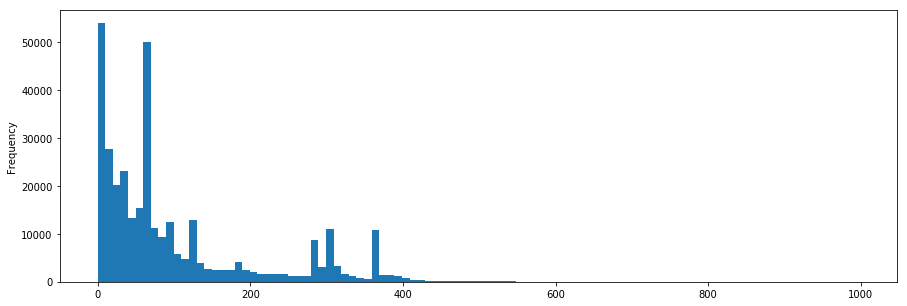

In [101]:
df[df.sec_diff<1000].sec_diff.plot(kind='hist',bins=100,figsize=(15,5))
#majority of sec diff is < 200

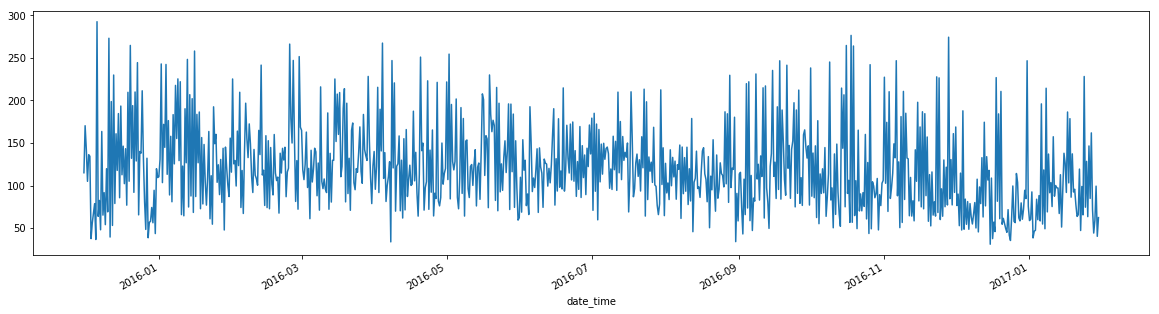

In [4]:
df[df.sec_diff<1000].set_index('date_time').sec_diff.resample('12H').mean().plot(figsize=(20,5))

In [6]:
df_month = df[(df.year==2016) & (df.month==9)]

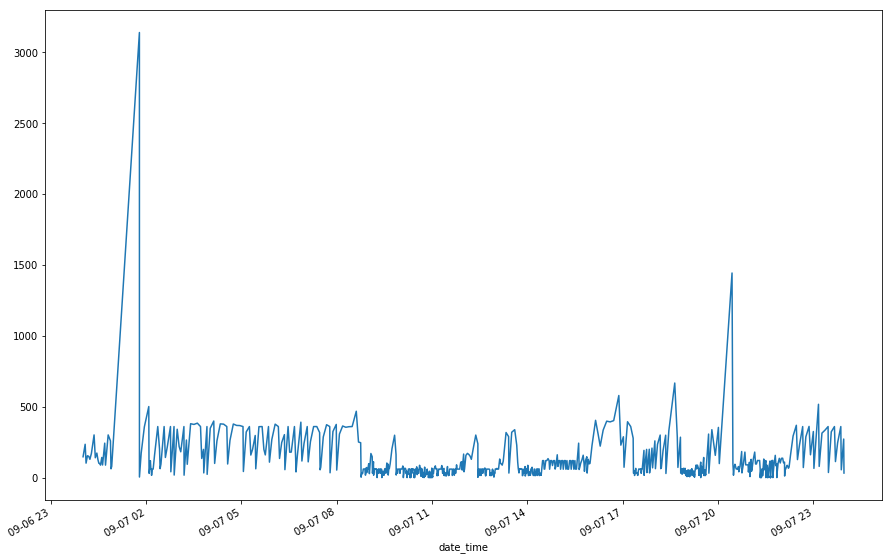

In [22]:
df_month[(df_month.sec_diff<6000) & (df_month.day==7)].set_index('date_time').sec_diff.plot(figsize=(15,10))

For a typical work day, time diff is bigger during sleep time (before 9 am), smaller (more condense) during work time, and a mix between big and small during night time?

# identify abnormal speed

In [59]:
df = pd.read_feather(PATH/'houston_processed_miles_time_diff.feather')

In [83]:
# max mps
max_mps=90/3600 

In [ ]:
df_timediff = df[df.sec_diff!=0]
df_abnormal=df_timediff[df_timediff.mile_diff / df_timediff.sec_diff >= max_mps]

In [116]:
df_abnormal[(df_abnormal.mile_diff>1) & (df_abnormal.mile_diff<15 )].shape
# keeping small glitches (<1 miles) and plane travel (probably > 15 miles)
abnormal_idx = df_abnormal[(df_abnormal.mile_diff>1) & (df_abnormal.mile_diff<15 )].index

In [117]:
df.drop(abnormal_idx,inplace=True)

In [118]:
# at this point, mile diff and sec diff have to be recalculated. Remove them for now
df.drop(['mile_diff','sec_diff'],axis=1,inplace=True)

In [120]:
df.reset_index(drop=True,inplace=True)

In [ ]:
# df.to_feather(PATH/'houston_ready.feather')

# Geographics

# TODO: single feature EDA

In [9]:
(df.isnull().sum() / len(df)) * 100

accuracy              0.000000
altitude             51.663826
heading              83.053367
latitudeE7            0.000000
longitudeE7           0.000000
timestampMs           0.000000
velocity             98.378713
verticalAccuracy    100.000000
act_conf1            47.112860
act_type1            47.112860
act_cont2            74.106045
act_type2            74.106045
extra_intVal         99.985585
extra_name           99.985585
extra_type           99.985585
dtype: float64

## take a look at feature with high % NaN

In [11]:
df.heading.describe()
# look like degree

count    59956.000000
mean       186.884615
std        101.600448
min          0.000000
25%        107.000000
50%        180.000000
75%        278.000000
max        359.000000
Name: heading, dtype: float64

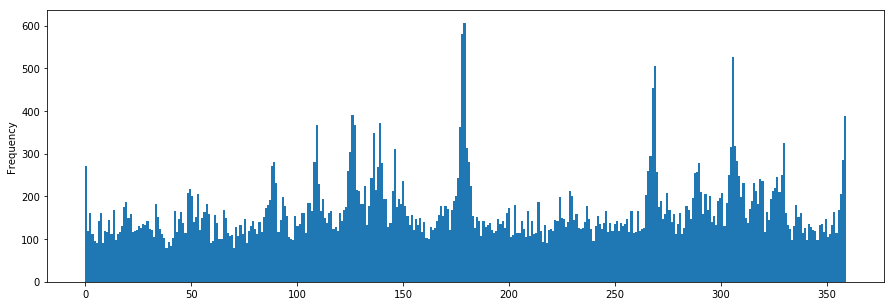

In [39]:
df.heading.plot(kind='hist',bins=360,figsize=(15,5))

In [19]:
df.velocity.describe()

count    5736.000000
mean        2.391039
std         5.903613
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        34.000000
Name: velocity, dtype: float64

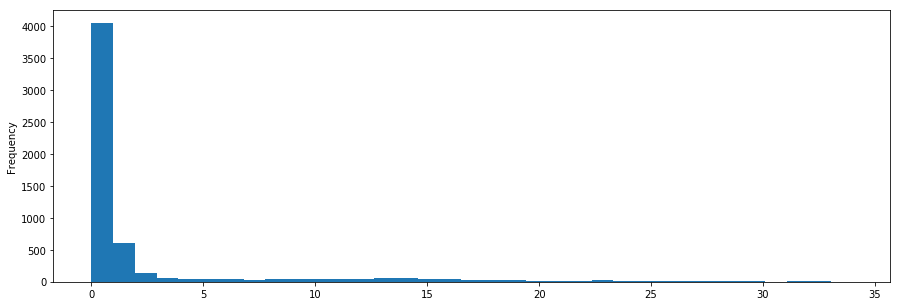

In [44]:
df.velocity.plot(kind='hist',bins=35,figsize=(15,5))

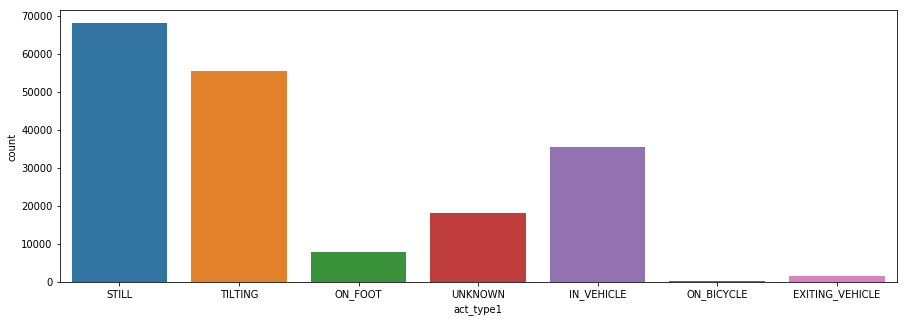

In [51]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(ax=ax,x=df.act_type1,data=df)

In [20]:
df.extra_type.value_counts()

VALUE    51
Name: extra_type, dtype: int64

# TODO: clustering and plotting cluster

# TODO: identify weekday and weekend point

# TODO: identify 'home' and 'work' cluster

# TODO: identify 'vacation' and other clusters